In [2]:
import requests
import os
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchmetrics
from torchmetrics import MetricCollection, MeanMetric, Accuracy, F1Score, Precision, Recall, AUROC, ConfusionMatrix
import tensorboard
import torch.optim as optim
from tqdm.notebook import tqdm 
import seaborn as sns

from dataclasses import dataclass, field
from typing import Dict, Tuple, Optional, Any

In [3]:
@dataclass
class CONFIG:
    # General Setting
    SEED: int = 42
    DEVICE: str = 'cuda:0'
    PRETRAINED: bool = True
    MODEL_NAME: str = 'mobilenetv3'

    # Dataset and DataLoader setting
    IMG_SIZE: int = 224
    DATASET_PATH: str = './dataset'
    SPLIT_RATIOS: Dict[str, float] = field(default_factory = lambda:{
        'train': 0.8,
        'test': 0.2,
    })
    NUM_CLASSES: int = 10
    BATCH_SIZE: int = 32  # Batch size for training
    NUM_WORKERS: int = 4  # Number of workers for DataLoader
    PIN_MEMORY: bool = True  # Pin memory for faster data transfer to GPU

     # Training settings
    NUM_EPOCHS: int = 50
    VALIDATION_FREQ: int = 1  # Frequency (in epochs) to perform validation
    CHECKPOINT_PATH: str = './checkpoints'  # Directory to save model checkpoints
    SAVE_BEST_MODEL: bool = True  # Save only the best model
    EARLY_STOPPING: Dict[str, Any] = field(default_factory = lambda: {
        'enabled': True,
        'patience': 10,
        'min_delta': 0.001
    })

    # Optimizer settings 
    OPTIMIZER: str = 'Adam'  # Optimizer type
    OPTIMIZER_PARAMS: Dict[str, float] = field(default_factory = lambda: {
        'lr': 1e-3,  # Initial learning rate
        'weight_decay': 1e-4
    })
    ADAM_BETAS: Tuple[float, float] = (0.9, 0.999)

    # Learning rate scheduler
    SCHEDULER: str = 'CosineAnnealingLR'
    SCHEDULER_PARAMS: Dict[str, Any] = field(default_factory = lambda: {
        'T_max': 50,
        'eta_min': 1e-6
    })

    # Loss function
    LOSS_FN: str = 'CrossEntropyLoss'
    LOSS_PARAMS: Dict[str, Any] = field(default_factory=dict)

    # Logging and monitoring
    OUTPUT_DIR = "./output"
    LOG_FREQ: int = 100
    METRIC_TO_MONITOR: str = 'top1_acc'
    MONITOR_MODE: str = 'max'

    # --- ADDED FOR TENSORBOARD ---
    TENSORBOARD_LOG_DIR: str = './tnsboard/trashnet'

    def __post_init__(self):
        # Validate parameters
        if not isinstance(self.DATASET_PATH, str) or not self.DATASET_PATH:
            raise ValueError("DATASET_PATH must be a non-empty string")
        if self.IMG_SIZE <= 0:
            raise ValueError("IMG_SIZE must be positive")
        if self.BATCH_SIZE <= 0:
            raise ValueError("BATCH_SIZE must be positive")
        if abs(sum(self.SPLIT_RATIOS.values()) - 1.0) > 1e-6:
            raise ValueError("SPLIT_RATIOS must sum to 1.0")
        if self.NUM_EPOCHS <= 0:
            raise ValueError("NUM_EPOCHS must be positive")
        # Update SCHEDULER_PARAMS['T_max'] to match NUM_EPOCHS
        if self.SCHEDULER == 'CosineAnnealingLR':
            object.__setattr__(self, 'SCHEDULER_PARAMS', {
                **self.SCHEDULER_PARAMS,
                'T_max': self.NUM_EPOCHS
            })
    

## Dataset and DataLoader setting

In [4]:
config = CONFIG()
config.DATASET_PATH = 'data/dataset-resized'

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees = 15),
        transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

}

config.TRANSFORMS = data_transforms
config.NUM_EPOCHS = 50


In [5]:
torch.manual_seed(config.SEED)
full_dataset = ImageFolder(config.DATASET_PATH, transform = None)

config.NUM_CLASSES = len(full_dataset.classes)

train_size = int(config.SPLIT_RATIOS['train'] * len(full_dataset))
test_size  = len(full_dataset) - train_size

# Create separate datasets with appropriate transforms
train_dataset = ImageFolder(config.DATASET_PATH, transform = config.TRANSFORMS['train'])
test_dataset = ImageFolder(config.DATASET_PATH, transform = config.TRANSFORMS['test'])

# Randomly split indices instead of dataset directly
indices = torch.randperm(len(full_dataset)).tolist()
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
test_dataset = torch.utils.data.Subset(test_dataset, test_indices)

# Print dataset shapes
print('Train dataset shape: ', len(train_dataset))
print('Test dataset shape: ', len(test_dataset))

Train dataset shape:  2021
Test dataset shape:  506


In [6]:
label_names = full_dataset.classes
label_counts = Counter([label_names[labels] for _, labels in full_dataset])
label_counts

Counter({'paper': 594,
         'glass': 501,
         'plastic': 482,
         'metal': 410,
         'cardboard': 403,
         'trash': 137})

In [7]:
label_counts.items()

dict_items([('cardboard', 403), ('glass', 501), ('metal', 410), ('paper', 594), ('plastic', 482), ('trash', 137)])

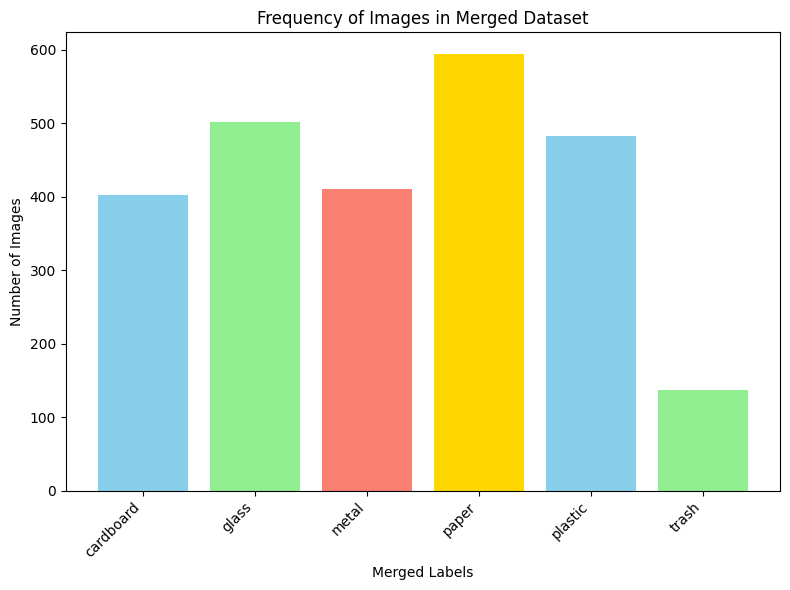

cardboard: 403 images
glass: 501 images
metal: 410 images
paper: 594 images
plastic: 482 images
trash: 137 images


In [8]:
label_names = full_dataset.classes
label_counts = Counter([label_names[labels] for _, labels in full_dataset])

# Plot the frequency
labels = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
plt.xlabel("Merged Labels")
plt.ylabel("Number of Images")
plt.title("Frequency of Images in Merged Dataset")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

for label, counts in label_counts.items():
    print(f'{label}: {counts} images')

In [9]:
total_weight = sum(label_counts.values())
class_weights = [total_weight / label_counts[i] for i in label_counts.keys()]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(config.DEVICE)
class_weights_tensor


tensor([ 6.2705,  5.0439,  6.1634,  4.2542,  5.2427, 18.4453], device='cuda:0')

In [10]:
train_loader = DataLoader(
    train_dataset,
    config.BATCH_SIZE,
    shuffle = True,
    num_workers = config.NUM_WORKERS,
    pin_memory = config.PIN_MEMORY
)

test_loader = DataLoader(
    test_dataset,
    config.BATCH_SIZE,
    shuffle = True,
    num_workers = config.NUM_WORKERS,
    pin_memory = config.PIN_MEMORY
)

Display images

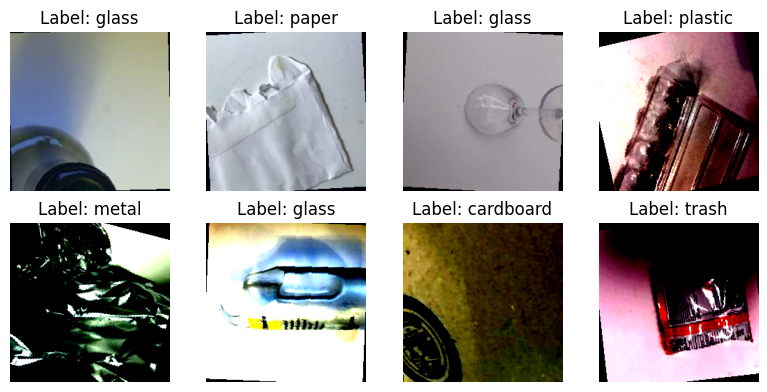

In [11]:
def denormalize(image, mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616)):
    """
    Denormalize a normalized image tensor for visualization.
    
    Args:
        image (torch.Tensor): Normalized image tensor (C, H, W)
        mean (tuple): Mean used for normalization
        std (tuple): Standard deviation used for normalization
    
    Returns:
        torch.Tensor: Denormalized image tensor
    """
    img = image.clone()  # Avoid modifying the original tensor
    for i in range(3):  # Apply denormalization per channel
        img[i] = img[i] * std[i] + mean[i]
    return img.clamp(0, 1)  # Ensure pixel values are in [0, 1]


first_batch = next(iter(train_loader))  # Assumes dataloader is defined
images, labels = first_batch

# Plotting
with torch.no_grad():  # No gradients for visualization
    batch_size = images.shape[0]
    fig, axes = plt.subplots(2, 4, figsize=(4 * 2, 4))
    axes = axes.flatten()

    # Denormalize the entire batch at once
    images_denorm = denormalize(images,
                                mean = [0.485, 0.456, 0.406],
                                std = [0.229, 0.224, 0.225]).cpu()  # Move to CPU for plotting

    # Plot each image
    for i in range(8):
        img = images_denorm[i].permute(1, 2, 0).numpy()  # Convert to (H, W, C)
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label_names[labels[i].item()]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


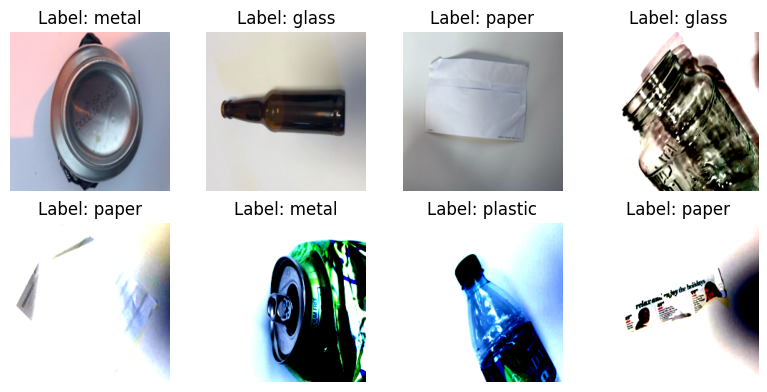

In [12]:
first_batch = next(iter(test_loader))  # Assumes dataloader is defined
images, labels = first_batch

# Plotting
with torch.no_grad():  # No gradients for visualization
    batch_size = images.shape[0]
    fig, axes = plt.subplots(2, 4, figsize=(4 * 2, 4))
    axes = axes.flatten()

    # Denormalize the entire batch at once
    images_denorm = denormalize(images,
                                mean = [0.485, 0.456, 0.406],
                                std = [0.229, 0.224, 0.225]).cpu()  # Move to CPU for plotting

    # Plot each image
    for i in range(8):
        img = images_denorm[i].permute(1, 2, 0).numpy()  # Convert to (H, W, C)
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label_names[labels[i].item()]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


## Declaring the models

In [13]:
import torchvision.models as models

# Load the MobileNetV3_Small model
model = models.mobilenet_v3_small(weights = models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)

# Modify the classifier to match the number of our output classes
num_classes = len(label_names)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

model = model.to(config.DEVICE)

print("MobileNetV3_Small model loaded and classifier modified.")


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 106MB/s]

MobileNetV3_Small model loaded and classifier modified.


In [14]:
# Function of supervised training
def train_one_epoch(config, model, train_loader, criterion, optimizer, 
                    scaler = None, scheduler = None):
    """
    Trains the model for one epoch and returns the metrics.
    Uses torchmetrics for robust metric calculation.

    Note: if you turn prob_ratio = 0, the mixup and cutmix augmentation is turn off 
    """
    model.train()
    # Intialize metrics

    metrics = MetricCollection({
        'acc': torchmetrics.Accuracy(task = "multiclass", 
                                     num_classes = config.NUM_CLASSES,
                                    average='micro'),
        'loss': MeanMetric()  # Added for consistency, but not used in pretraining
    }).to(config.DEVICE)


    # Define progress bar only for rank 0
    progress_bar = tqdm(train_loader, desc=f"Training", leave=False)

    for idx, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(config.DEVICE), labels.to(config.DEVICE)
        
        optimizer.zero_grad(set_to_none = True)
        
        if scaler:
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
                
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        # Step scheduler (per batch)
        if scheduler:
            scheduler.step()
            
        # Update torchmetrics
        metrics["loss"].update(loss.item())
        metrics["acc"].update(outputs, labels)

        if idx % config.LOG_FREQ == 0:
            progress_bar.set_postfix({
                'loss': metrics["loss"].compute().item(),
                'acc': metrics["acc"].compute().item()
            })

    final_metrics = metrics.compute()        
    # Reset metrics for the next epoch
    metrics.reset()

    return final_metrics


In [15]:
# Function of supervised training
def evaluate(config, model, data_loader):
    """
    Trains the model for one epoch and returns the metrics.
    Uses torchmetrics for robust metric calculation.

    Note: if you turn prob_ratio = 0, the mixup and cutmix augmentation is turn off 
    """
    model.eval()
    criterion = nn.CrossEntropyLoss()
    metrics = MetricCollection({
        'top1_acc': Accuracy(task="multiclass", num_classes=config.NUM_CLASSES, top_k=1),
        'precision': Precision(task="multiclass", num_classes=config.NUM_CLASSES, average='macro'),
        'f1_score': F1Score(task="multiclass", num_classes=config.NUM_CLASSES, average='weighted'),
        'precision': Precision(task="multiclass", num_classes=config.NUM_CLASSES, average='weighted'),
        'recall': Recall(task="multiclass", num_classes=config.NUM_CLASSES, average='weighted'),
        'auc_roc': AUROC(task="multiclass", num_classes=config.NUM_CLASSES, average='weighted'),
        'loss': MeanMetric()
    }).to(config.DEVICE)
    confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=config.NUM_CLASSES).to(config.DEVICE)

    progress_bar = tqdm(data_loader, desc="Evaluation", leave=False)
    with torch.no_grad():
        for images, labels in progress_bar:
            images, labels = images.to(config.DEVICE), labels.to(config.DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            metrics["loss"].update(loss.item())
            metrics["top1_acc"].update(outputs, labels)
            metrics["f1_score"].update(outputs, labels)
            metrics["precision"].update(outputs, labels)
            metrics["recall"].update(outputs, labels)
            metrics["auc_roc"].update(outputs, labels)
            confusion_matrix.update(outputs, labels)

            progress_bar.set_postfix({
                'loss': metrics["loss"].compute().item(),
                'top1_acc': metrics["top1_acc"].compute().item()
            })

    final_metrics = metrics.compute()
    final_metrics['confusion_matrix'] = confusion_matrix.compute().cpu().numpy()
    metrics.reset()
    confusion_matrix.reset()
    return final_metrics



In [16]:
optimizer_params = config.OPTIMIZER_PARAMS.copy()
if config.OPTIMIZER == 'Adam':
    optimizer = optim.Adam(
        model.parameters(),
        **optimizer_params,
        betas=config.ADAM_BETAS
    )
else:
    raise ValueError(f"Unsupported optimizer: {config.OPTIMIZER}")

# Initialize scheduler
if config.SCHEDULER == 'CosineAnnealingLR':
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        **config.SCHEDULER_PARAMS
    )
else:
    raise ValueError(f"Unsupported scheduler: {config.SCHEDULER}")

config.LOSS_PARAMS = {
    "weight": class_weights_tensor,
    "label_smoothing": 0.1
}
if config.LOSS_FN == 'CrossEntropyLoss':
    loss_fn = nn.CrossEntropyLoss(**config.LOSS_PARAMS)
else:
    raise ValueError(f"Unsupported scheduler: {config.LOSS_FN}")

# Initialize mixed precision scaler
loss_scaler = torch.cuda.amp.GradScaler() if config.DEVICE == 'cuda' else None

In [17]:
import torch
from torch.utils.tensorboard import SummaryWriter  # Import TensorBoard writer
import os

# Initialize TensorBoard Writer
# This creates the folder './tnsboard/trashnet' automatically
os.makedirs(config.TENSORBOARD_LOG_DIR, exist_ok = True)
writer = SummaryWriter(log_dir=config.TENSORBOARD_LOG_DIR)

# Initialize early stopping variables
best_metric = float('-inf') if config.MONITOR_MODE == 'max' else float('inf')
patience_counter = 0
best_model_path = os.path.join(config.CHECKPOINT_PATH, 'best_model_v2.pth')

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

print(f"TensorBoard logging started at: {config.TENSORBOARD_LOG_DIR}")

for epoch in range(0, config.NUM_EPOCHS):
    # --- TRAINING ---
    train_metrics = train_one_epoch(
        config, model, train_loader, loss_fn, optimizer, 
        scaler=loss_scaler, scheduler=scheduler
    )
    
    train_loss = train_metrics['loss'].item()
    train_acc = train_metrics['acc'].item()
    
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    
    # --- EVALUATION ---
    eval_metrics = evaluate(config, model, test_loader)
    
    val_loss = eval_metrics['loss'].item()
    val_acc = eval_metrics['top1_acc'].item()
    
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    # --- LOGGING TO TENSORBOARD ---
    # Log Train metrics
    writer.add_scalar('Train/Loss', train_loss, epoch)
    writer.add_scalar('Train/Accuracy', train_acc, epoch)
    
    # Log Validation metrics
    writer.add_scalar('Eval/Loss', val_loss, epoch)
    writer.add_scalar('Eval/Top1_Accuracy', val_acc, epoch)
    writer.add_scalar('Eval/F1_Score', eval_metrics['f1_score'].item(), epoch)
    
    # Log Learning Rate (helpful to see scheduler behavior)
    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar('Training/Learning_Rate', current_lr, epoch)

    # Print to console
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f} | Train Acc = {train_acc * 100:.2f}%")
    print(f"Epoch {epoch + 1}: Eval Loss = {val_loss:.4f} | Val Acc = {val_acc * 100:.2f}%")

    # --- SAVE BEST MODEL ---
    current_metric = eval_metrics[config.METRIC_TO_MONITOR].item()
    
    if config.SAVE_BEST_MODEL:
        if (config.MONITOR_MODE == 'max' and current_metric > best_metric) or \
           (config.MONITOR_MODE == 'min' and current_metric < best_metric):
            best_metric = current_metric
            os.makedirs(config.CHECKPOINT_PATH, exist_ok=True)
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model at epoch {epoch + 1} with {config.METRIC_TO_MONITOR}: {best_metric:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1

    # --- EARLY STOPPING ---
    if config.EARLY_STOPPING['enabled'] and patience_counter >= config.EARLY_STOPPING['patience']:
        print(f"Early stopping triggered after {patience_counter} epochs without improvement")
        break

# Close the writer after training finishes
writer.close()
print("Training finished. TensorBoard writer closed.")

TensorBoard logging started at: ./tnsboard/trashnet


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1: Train Loss = 1.3127 | Train Acc = 58.98%
Epoch 1: Eval Loss = 0.8999 | Val Acc = 68.18%
Saved best model at epoch 1 with top1_acc: 0.6818


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2: Train Loss = 1.1020 | Train Acc = 69.77%
Epoch 2: Eval Loss = 0.6713 | Val Acc = 77.08%
Saved best model at epoch 2 with top1_acc: 0.7708


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.9480 | Train Acc = 78.77%
Epoch 3: Eval Loss = 0.5671 | Val Acc = 82.61%
Saved best model at epoch 3 with top1_acc: 0.8261


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.9779 | Train Acc = 79.61%
Epoch 4: Eval Loss = 0.6164 | Val Acc = 80.24%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5: Train Loss = 0.8965 | Train Acc = 81.84%
Epoch 5: Eval Loss = 0.6795 | Val Acc = 78.06%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6: Train Loss = 0.8751 | Train Acc = 84.41%
Epoch 6: Eval Loss = 0.7916 | Val Acc = 75.10%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7: Train Loss = 0.8864 | Train Acc = 82.38%
Epoch 7: Eval Loss = 0.5058 | Val Acc = 85.77%
Saved best model at epoch 7 with top1_acc: 0.8577


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8: Train Loss = 0.8425 | Train Acc = 86.29%
Epoch 8: Eval Loss = 0.6606 | Val Acc = 78.85%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9: Train Loss = 0.8171 | Train Acc = 86.24%
Epoch 9: Eval Loss = 0.3938 | Val Acc = 86.96%
Saved best model at epoch 9 with top1_acc: 0.8696


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10: Train Loss = 0.8329 | Train Acc = 86.44%
Epoch 10: Eval Loss = 0.6283 | Val Acc = 81.82%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11: Train Loss = 0.7692 | Train Acc = 89.21%
Epoch 11: Eval Loss = 0.7241 | Val Acc = 77.27%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12: Train Loss = 0.8027 | Train Acc = 87.09%
Epoch 12: Eval Loss = 0.4710 | Val Acc = 86.56%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13: Train Loss = 0.7673 | Train Acc = 88.52%
Epoch 13: Eval Loss = 0.4848 | Val Acc = 86.96%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14: Train Loss = 0.7269 | Train Acc = 90.90%
Epoch 14: Eval Loss = 0.4765 | Val Acc = 85.18%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15: Train Loss = 0.7830 | Train Acc = 87.43%
Epoch 15: Eval Loss = 0.4393 | Val Acc = 87.15%
Saved best model at epoch 15 with top1_acc: 0.8715


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16: Train Loss = 0.7741 | Train Acc = 89.61%
Epoch 16: Eval Loss = 0.5408 | Val Acc = 83.79%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17: Train Loss = 0.7280 | Train Acc = 90.70%
Epoch 17: Eval Loss = 0.4178 | Val Acc = 88.34%
Saved best model at epoch 17 with top1_acc: 0.8834


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18: Train Loss = 0.7440 | Train Acc = 89.86%
Epoch 18: Eval Loss = 0.4658 | Val Acc = 86.96%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19: Train Loss = 0.7314 | Train Acc = 90.45%
Epoch 19: Eval Loss = 0.6784 | Val Acc = 78.66%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20: Train Loss = 0.7198 | Train Acc = 90.60%
Epoch 20: Eval Loss = 0.4467 | Val Acc = 88.34%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 21: Train Loss = 0.7388 | Train Acc = 90.40%
Epoch 21: Eval Loss = 0.4104 | Val Acc = 88.54%
Saved best model at epoch 21 with top1_acc: 0.8854


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 22: Train Loss = 0.7268 | Train Acc = 91.44%
Epoch 22: Eval Loss = 0.4983 | Val Acc = 85.57%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 23: Train Loss = 0.7202 | Train Acc = 91.54%
Epoch 23: Eval Loss = 0.3851 | Val Acc = 90.32%
Saved best model at epoch 23 with top1_acc: 0.9032


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 24: Train Loss = 0.7366 | Train Acc = 91.39%
Epoch 24: Eval Loss = 0.5133 | Val Acc = 84.39%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 25: Train Loss = 0.6826 | Train Acc = 92.68%
Epoch 25: Eval Loss = 0.5014 | Val Acc = 85.57%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 26: Train Loss = 0.7287 | Train Acc = 91.29%
Epoch 26: Eval Loss = 0.3989 | Val Acc = 90.51%
Saved best model at epoch 26 with top1_acc: 0.9051


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 27: Train Loss = 0.7120 | Train Acc = 91.19%
Epoch 27: Eval Loss = 0.4897 | Val Acc = 86.36%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 28: Train Loss = 0.7003 | Train Acc = 91.19%
Epoch 28: Eval Loss = 0.4174 | Val Acc = 87.55%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 29: Train Loss = 0.7201 | Train Acc = 90.70%
Epoch 29: Eval Loss = 0.4164 | Val Acc = 89.13%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 30: Train Loss = 0.7123 | Train Acc = 91.54%
Epoch 30: Eval Loss = 0.5137 | Val Acc = 86.17%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 31: Train Loss = 0.6931 | Train Acc = 92.83%
Epoch 31: Eval Loss = 0.3932 | Val Acc = 90.12%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 32: Train Loss = 0.7349 | Train Acc = 91.04%
Epoch 32: Eval Loss = 0.4887 | Val Acc = 86.96%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 33: Train Loss = 0.6749 | Train Acc = 93.27%
Epoch 33: Eval Loss = 0.6409 | Val Acc = 81.82%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 34: Train Loss = 0.6905 | Train Acc = 92.92%
Epoch 34: Eval Loss = 0.3740 | Val Acc = 89.92%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 35: Train Loss = 0.7072 | Train Acc = 92.28%
Epoch 35: Eval Loss = 0.4526 | Val Acc = 85.97%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 36: Train Loss = 0.6659 | Train Acc = 93.72%
Epoch 36: Eval Loss = 0.5613 | Val Acc = 82.41%
Early stopping triggered after 10 epochs without improvement
Training finished. TensorBoard writer closed.


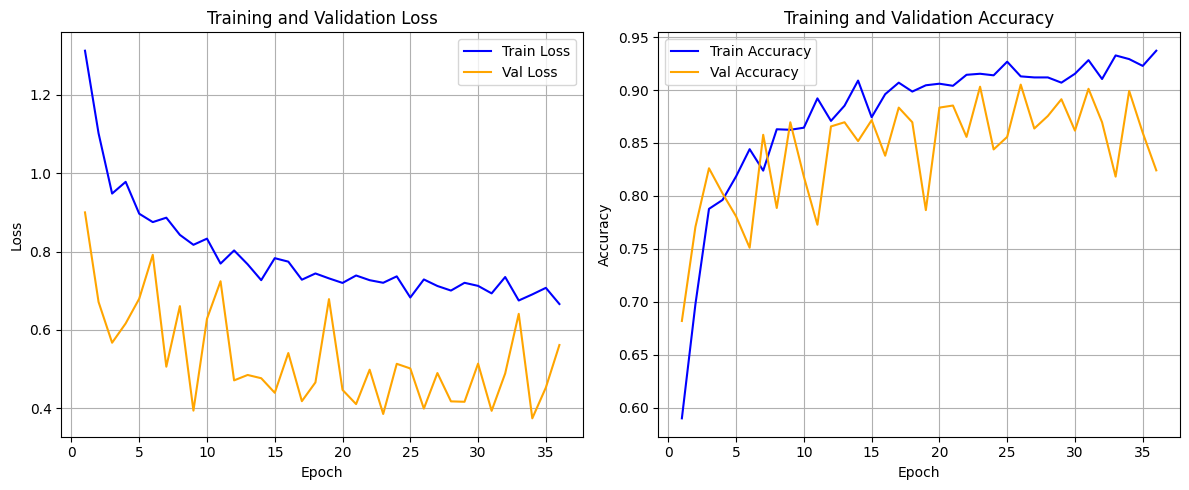

In [18]:
# Plot loss and accuracy
os.makedirs(config.OUTPUT_DIR, exist_ok = True)
epochs = range(1, len(train_loss_list) + 1)
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label='Train Loss', color='blue')
plt.plot(epochs, val_loss_list, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_list, label='Train Accuracy', color='blue')
plt.plot(epochs, val_acc_list, label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_DIR, 'training_metrics.png'))
plt.show()

### Evaluation

In [19]:
# Load the MobileNetV3_Small model
model = models.mobilenet_v3_small()
best_model_path = os.path.join(config.CHECKPOINT_PATH, 'best_model_v2.pth')

# Modify the classifier to match the number of our output classes
model.classifier[3] = nn.Linear(model.classifier[3].in_features, config.NUM_CLASSES)

model = model.to(config.DEVICE)

# Load best model for prediction
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    print("Loaded best model for prediction")

model.eval()
metric = evaluate(config, model, test_loader)
print(metric)

Loaded best model for prediction


Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

{'auc_roc': tensor(0.9853, device='cuda:0'), 'f1_score': tensor(0.9042, device='cuda:0'), 'loss': tensor(0.4058, device='cuda:0'), 'precision': tensor(0.9058, device='cuda:0'), 'recall': tensor(0.9051, device='cuda:0'), 'top1_acc': tensor(0.9051, device='cuda:0'), 'confusion_matrix': array([[ 73,   0,   0,   4,   0,   0],
       [  1,  95,   4,   1,   4,   0],
       [  0,   6,  77,   1,   2,   0],
       [  0,   0,   0, 113,   0,   3],
       [  1,   5,   3,   4,  76,   0],
       [  2,   0,   2,   5,   0,  24]])}


In [20]:
metric

{'auc_roc': tensor(0.9853, device='cuda:0'),
 'f1_score': tensor(0.9042, device='cuda:0'),
 'loss': tensor(0.4058, device='cuda:0'),
 'precision': tensor(0.9058, device='cuda:0'),
 'recall': tensor(0.9051, device='cuda:0'),
 'top1_acc': tensor(0.9051, device='cuda:0'),
 'confusion_matrix': array([[ 73,   0,   0,   4,   0,   0],
        [  1,  95,   4,   1,   4,   0],
        [  0,   6,  77,   1,   2,   0],
        [  0,   0,   0, 113,   0,   3],
        [  1,   5,   3,   4,  76,   0],
        [  2,   0,   2,   5,   0,  24]])}

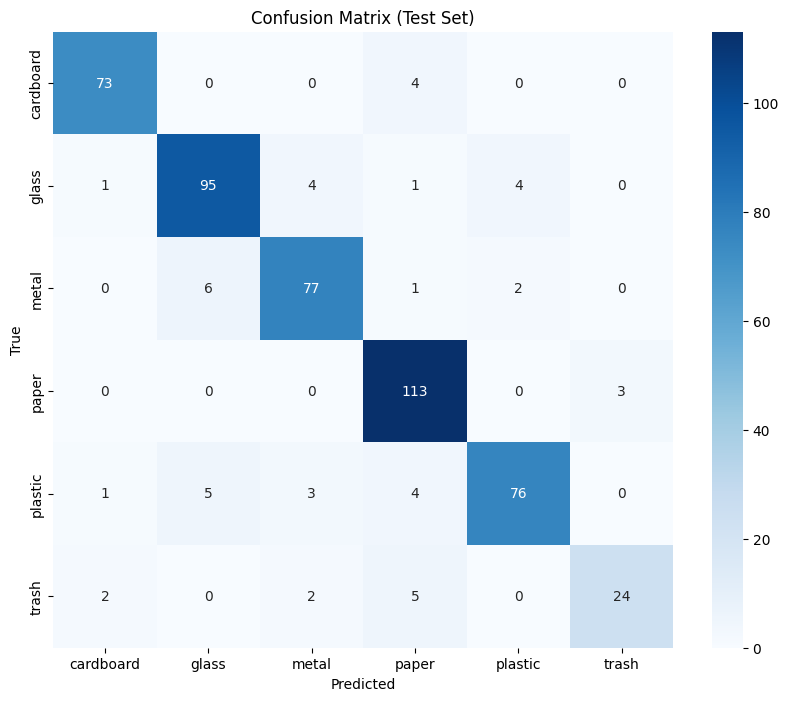

In [21]:
# Plot confusion matrix
cm = metric['confusion_matrix']
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(os.path.join(config.OUTPUT_DIR, 'confusion_matrix.png'))
plt.show()

  True Class: glass
  Predicted Class: glass
  Confidence: 90.66%


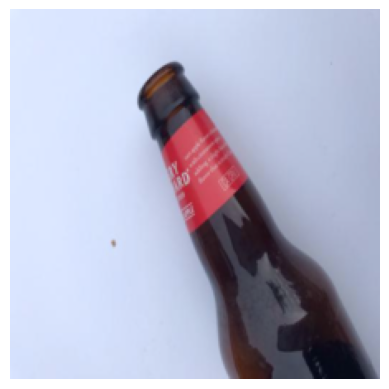

  True Class: glass
  Predicted Class: metal
  Confidence: 42.73%


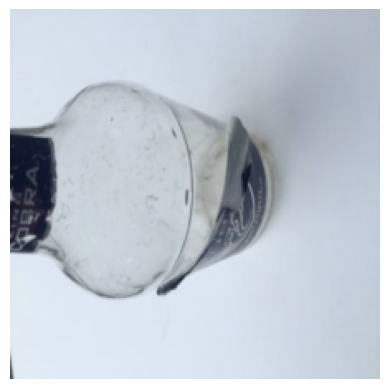

  True Class: paper
  Predicted Class: paper
  Confidence: 88.41%


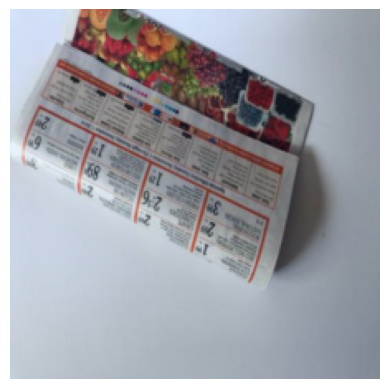

  True Class: metal
  Predicted Class: metal
  Confidence: 90.56%


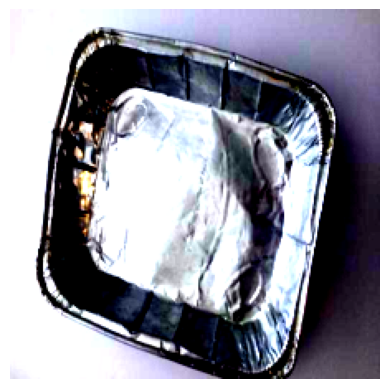

  True Class: glass
  Predicted Class: glass
  Confidence: 92.06%


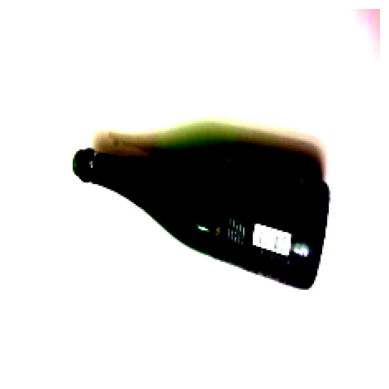

  True Class: trash
  Predicted Class: trash
  Confidence: 91.92%


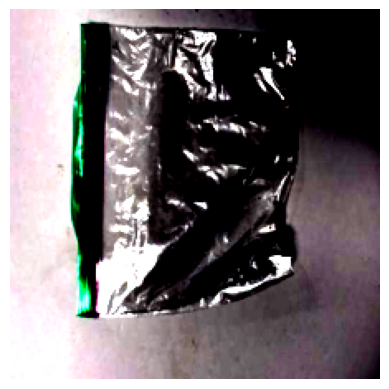

  True Class: paper
  Predicted Class: paper
  Confidence: 87.14%


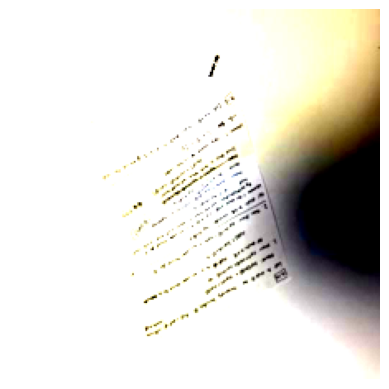

  True Class: glass
  Predicted Class: glass
  Confidence: 92.12%


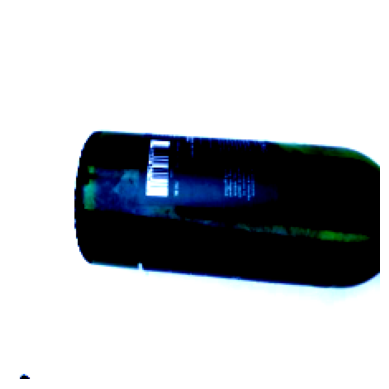

In [22]:
# Predict and display 8 images
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(config.DEVICE), labels.to(config.DEVICE)
with torch.no_grad():
    outputs = model(images)
    probabilities = torch.softmax(outputs, dim=1)
    predicted_probs, predicted = torch.max(probabilities, 1)
    

# Plot predictions
images_denorm = denormalize(
    images,
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225]
).cpu()

num_images_to_plot = 8
for i in range(0, num_images_to_plot):
    img = images_denorm[i].permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    true_label = label_names[labels[i].item()]
    predict_label = label_names[predicted[i].item()]
    confidence = predicted_probs[i].item() * 100
    print(f"  True Class: {true_label}")
    print(f"  Predicted Class: {predict_label}")
    print(f"  Confidence: {confidence:.2f}%")
    plt.imshow(img)
    plt.axis('off')
    plt.show()